# Modeling a Binary Star Population

## Intro
The Kepler satellite found a population of 27 stars rotating faster than expected for single stars.  After an initial analysis of the rapidly rotating stars with more detailed observations was inconclusive, we decided to build a more sophisticated model in Python.

This model aims to test the hypothesis that these rapidly rotating stars exhibits characteristics of spectroscopic binary systems influenced by tidal locking interactions.In a binary system, two objects orbit a common center of mass, bound together by gravity.

## Known Parameters

The known quantities of these stars include their rotational period acquired from McQuillan et al (2014) and the mass acquired from Berger et al (2020). Additionally, radial velocity measurements were collected using the Modspec instrument at the Michigan-Dartmouth-MIT (MDM) observatory.

In [2]:
from astropy.table import Table, join
import astropy.io.ascii as ascii
import astropy.io.fits
import warnings

# Suppress warnings:
def warn(*args, **kwargs):
    pass
warnings.warn = warn

def read_data():
    targets = Table.read('MDM_targets.csv', format = 'ascii.csv')
    targets.rename_column('ï»¿KIC', 'KIC')
    data_set1 = Table.read('ajab8a33t1_mrt.txt', format = 'ascii.mrt')
    data_set2 = Table.read('ajab8a33t2_mrt.txt', format = 'ascii.mrt')
    McQuillan = Table.read('McQuillan.fit', format = 'fits')
    
    #Join the datasets
    d1_d2 = join(data_set1, data_set2)
    targets = join(targets, d1_d2)
    table = join(targets, McQuillan, join_type = 'left', keys = 'KIC')
    
    return table

#Save table to a CSV file
def write_data():
    table = read_data()
    table.write('Target_data.csv', format = 'ascii.csv')

#Read saved table
def read_table():
    
    return Table.read('Target_data.csv')

#Create an index for KIC targets
def KIC_index():
    table = read_data()
    index = table['KIC']
    
    return index

import pickle
#Get observation times and radial velocities
def rv_times(KIC_number):
    with open('full_rvs.pickle', 'rb') as f:
        docs, full_rvs = pickle.load(f)
    KIC_times, KIC_rvs = full_rvs[f"KIC{KIC_number}"]
    
    return KIC_times, KIC_rvs

#Target Mass
def target_mass(KIC_number):
    table = read_table()
    target_mass = table['KIC', 'Mass']
    target_mass.add_index('KIC')
    mass = target_mass.loc[KIC_number]['Mass']
    
    return mass

#Target Orbital Period
def target_period(KIC_number):
    table = read_table()
    target_period = table['KIC', 'Prot']
    target_period.add_index('KIC')
    Prot = target_period.loc[KIC_number]['Prot']
    
    return Prot


## Modeled Unknown Parameters

The modeled unknown parameters include the inclination angle, mass ration (q), and phase angle (theta).

Inclination Angle:

The inclination angle is the angle between the plane of the orbit and the observer. The inclination angle of the binary orbit follows a sine distribution, this is because there’s almost an infinite number of ways to have a 90 degree inclination angle but there are only two ways of getting a 0 degree inclination angle.

Mass Ratio (q):

The mass ratio is the mass of the primary star divided by the mass of the secondary star. The mass ratio follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 1. 

Phase Angle (Theta):

The phase angle is the angle at which the first observation was made. The phase angle follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 2π. 


In [3]:
import numpy as np
from math import pi
from astropy import units as u

# Inclination angle
def sin_distn():
    rand_uniform_array = np.random.uniform(0, pi/2, 300)
    i_angle = np.arccos((2 * rand_uniform_array)/pi)
    
    return i_angle
inclination_angle_array = sin_distn()

# Mass ratio (primary mass / companion mass)
q_array = np.random.uniform(0,1, 200)


#Phase angle
theta_array = np.random.uniform(0,2*pi, 200) * u.radian

## Astronomy Functions

Using Kepler's Third Law of planetary motion, the time needed to complete an orbit squared is proportional to the semi-major axis of orbit cubed. Below is a function to calculate the amplitude (semi-major axis) of the binary system. 

In [4]:
from astropy import constants as const
Gravitational_constant = const.G # Value = 6.67 x 10^-11 m^3/(kg s^2)

# Amplitude (semi-major axis)
def calculate_amplitude(mass1, q_array, inclination_angle_array, period):
    mass2 = mass1 * q_array
    orbital_period = (period * u.day).to(u.second)
    total_mass = mass1 + mass2
    amplitude = (
        ( ((mass2**3) / (total_mass**2))
        * (np.sin(inclination_angle_array)**3)
        *((2 * pi * Gravitational_constant) / orbital_period))**(1/3)
        )
    return amplitude # units of m/s7713


In astronomy, radial velocity is an object’s motion towards or away from the observer. Using Kepler’s 3rd law of planetary motion, we created functions to calculate radial velocity, and add noise to account for errors in observations.

In [5]:
# Radial velocity
def calculate_radial_velocity(mass1, q_array, time_array, period , theta_array, inclination_angle_array):
    time_array = time_array.reshape(len(time_array), 1, 1, 1) 
    theta_array = theta_array.reshape(1, len(theta_array), 1, 1)
    q_array = q_array.reshape(1, 1, len(q_array),1)
    inclination_angle_array = inclination_angle_array.reshape(1, 1, 1, len(inclination_angle_array))
    
    amplitude = calculate_amplitude(mass1, q_array, inclination_angle_array, period)
    period =  period * u.day
    omega = (2*pi)/(period.to(u.second))
    radial_velocity = ((amplitude*np.cos(((omega*time_array).to(u.radian, equivalencies = u.dimensionless_angles())) + theta_array))) #units of m/s
    
    return radial_velocity # in m/s

# Add noise to radial velocity
def calculate_velocity_with_noise(mass1, q_array, time_array, period, std, theta_array, inclination_angle_array):
    radial_velocity_array = calculate_radial_velocity(mass1, q_array, time_array, period,theta_array,inclination_angle_array) #m/s
    noise = np.random.normal(0, std, size = radial_velocity_array.shape)  * (u.km/u.second)
    velocity_with_noise = radial_velocity_array + noise
    
    return (velocity_with_noise.to(u.km/u.s)) 


With the known and modeled parameters, our model can generate an array of radial velocities for each possible combination of parameters. However, one limitation of this research was the computational constraints of my computer.

In [6]:
SUN_MASS = const.M_sun # Value = 1.98840987e+30 kg

def generate_rv_array(KICnumber):
    time_array, measured_rv = rv_times(KICnumber)
    time_array = np.array(time_array) *u.day
    measured_rv = np.array(measured_rv) * (u.km/u.s)
    std = 10 # standard deviation in km/s
    mass = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber) 
    rv_array = calculate_velocity_with_noise(mass, q_array, time_array, t_period, std, theta_array, inclination_angle_array) #m/sec
    
    return rv_array # in km/s

Our model used a Chi-square statistical test to identify the best-fit radial velocity curve that best fits the motion of a binary star system. We then compare this modeled radial velocity curve with the actual radial velocity measurements obtained using the Modspec instrument at the Michigan-Dartmouth-MIT (MDM) Observatory.

In [7]:
def Chi_square_distribution(KICnumber):
    radial_velocities = generate_rv_array(KICnumber)
    time_array,measured_rv = rv_times(KICnumber)
    measured_rv = measured_rv * (u.km/u.s) #measured rv
    measured_rv = measured_rv.reshape(len(measured_rv), 1, 1, 1)
    chi_square = ((radial_velocities - measured_rv)**2) / ((10* u.km/u.s)**2)
    chi_values_array = np.sum(chi_square, axis = 0)
    
    return chi_values_array

In [8]:
def minimum(KICnumber):
    chi_values = Chi_square_distribution(KICnumber)
    min_value = chi_values.min() #returns the minimum value in the multidimensional array s
    max_value = chi_values.max()
    min_index = np.argwhere(chi_values == min_value)
    
    theta_value = theta_array[min_index[0][0]]
    q_value = q_array[min_index[0][1]]
    i_value = inclination_angle_array[min_index[0][2]]
    
    print(f"KIC target: KIC_{KICnumber}")
    print("max value is ", max_value)
    print("min value is ", min_value)
    print("theta value is ", theta_value)
    print("q value is ", q_value)
    print("inclination angle value is ", i_value)
    
    return [theta_value,q_value,i_value,min_value]

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def KIC_Model(KICnumber):
    #Declare paramters
    time_array, measured_rv = rv_times(KICnumber) 
    time_array = np.array(time_array) *u.day
    mass1 = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber)
    
    #Find minimum Chi-Square value and respective modeled parameters
    min_ = minimum(KICnumber)
    b_f_theta = np.array([min_[0].value]) * u.radian
    b_f_q = np.array([min_[1]])
    b_f_i = np.array([min_[2]])
    min_chi_value = np.array([min_[3]])
    #print(b_f_theta,b_f_q,b_f_i)

    #Hypothesis testing
    print('Experimental p value = ', min_chi_value)
    right_tail_value = stats.chi2.ppf(1-0.025, df = 2)#we use 2 degrees of freedom since we have 3 categories of modeled parameters, dof = n-1 = (theta, q, inc_angle) - 1
    print('Theoretical p value =', right_tail_value)
    if min_chi_value < right_tail_value:
        print('We have a binary system')
    elif min_chi_value > right_tail_value:
        print('We do not have a binary system')
    print("")

    
    #calculate best fit curve radial velocity and plot it with measured rv
    b_f_rv = calculate_radial_velocity(mass1, b_f_q, time_array, t_period, b_f_theta, b_f_i)
    sns.set()
    ax = plt.axes()
    ax.set(xlabel = 'time (days)', ylabel = 'radial velocity (km/sec)',
           title = f"KIC_{KICnumber} observed & measured rvs")
    plt.plot(time_array, (b_f_rv[:,0,0,0].to(u.km/u.s)).value, label = 'best fit rv curve', linestyle = ':')
    plt.plot(time_array,measured_rv, label = 'measured rv', linestyle = '-')
    plt.legend()
    plt.show()
    

index = KIC_index()

In [10]:
def Binary_Model():
    for i in index:
        KIC_Model(i)

## Results

KIC target: KIC_1570924
max value is  1112.441403973284
min value is  6.156409000895169
theta value is  0.05633832437350969 rad
q value is  0.01576631439121201
inclination angle value is  1.3438767108158558
Experimental p value =  [6.156409]
Theoretical p value = 7.377758908227871
We have a binary system



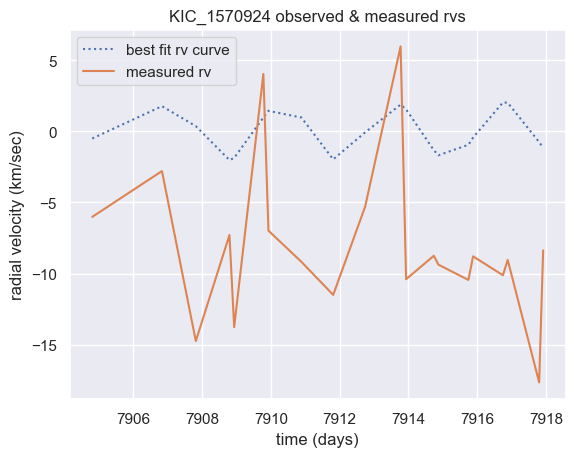

KIC target: KIC_3248885
max value is  1218.9583758369606
min value is  100.38147917400417
theta value is  6.217509338618033 rad
q value is  0.08937107370197728
inclination angle value is  1.1636217783844605
Experimental p value =  [100.38147917]
Theoretical p value = 7.377758908227871
We do not have a binary system



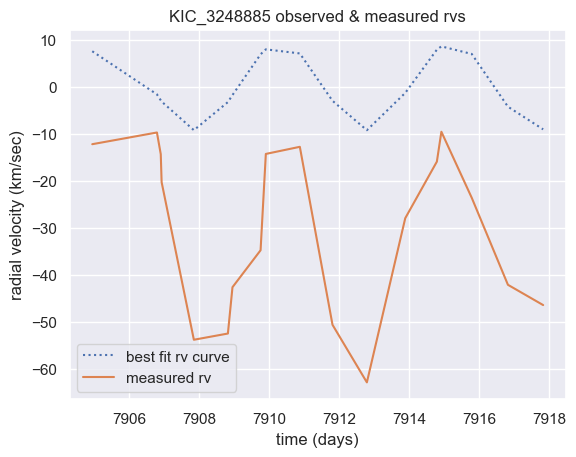

KIC target: KIC_3539632
max value is  1181.9060590759057
min value is  18.312154490761067
theta value is  2.3840397249218226 rad
q value is  0.18926981072842353
inclination angle value is  0.6393739607745
Experimental p value =  [18.31215449]
Theoretical p value = 7.377758908227871
We do not have a binary system



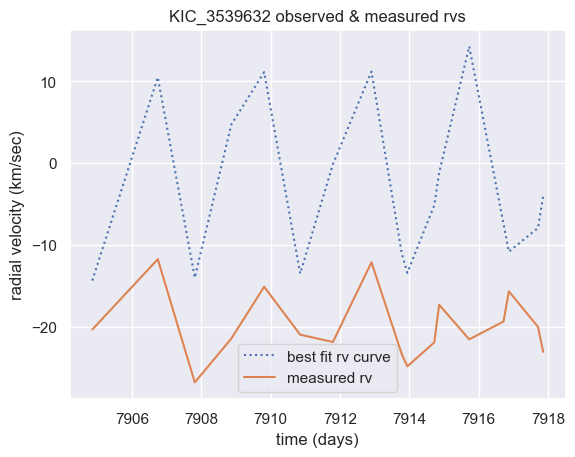

KIC target: KIC_3540728
max value is  1506.192637612472
min value is  30.80499771688955
theta value is  1.237016420452016 rad
q value is  0.19991126293789174
inclination angle value is  0.28956736769262625
Experimental p value =  [30.80499772]
Theoretical p value = 7.377758908227871
We do not have a binary system



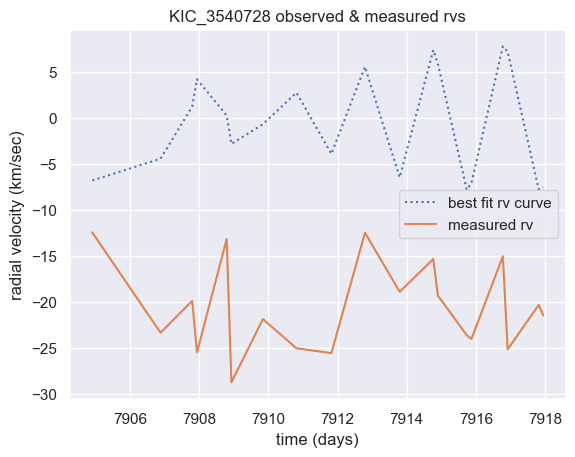

KIC target: KIC_4036736
max value is  1124.2433819660127
min value is  31.767994155602572
theta value is  5.535669268276775 rad
q value is  0.21346271932990557
inclination angle value is  0.22259189033809865
Experimental p value =  [31.76799416]
Theoretical p value = 7.377758908227871
We do not have a binary system



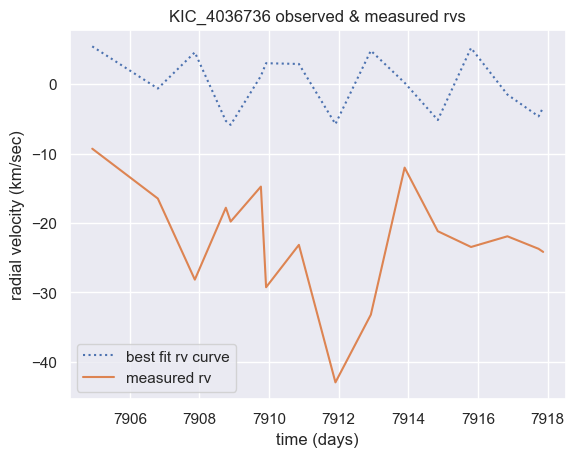

KIC target: KIC_4249702
max value is  921.6044606357943
min value is  26.728475772549604
theta value is  2.200052350043985 rad
q value is  0.320929415883221
inclination angle value is  0.22259189033809865
Experimental p value =  [26.72847577]
Theoretical p value = 7.377758908227871
We do not have a binary system



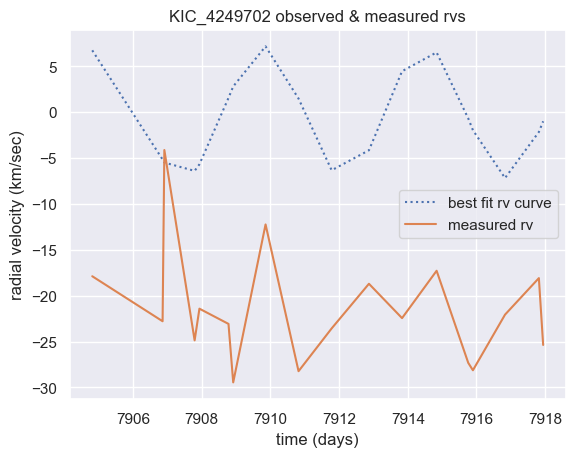

KIC target: KIC_4454890
max value is  1591.887644137655
min value is  42.70915931395536
theta value is  0.16113347648168877 rad
q value is  0.01576631439121201
inclination angle value is  0.8548536921762441
Experimental p value =  [42.70915931]
Theoretical p value = 7.377758908227871
We do not have a binary system



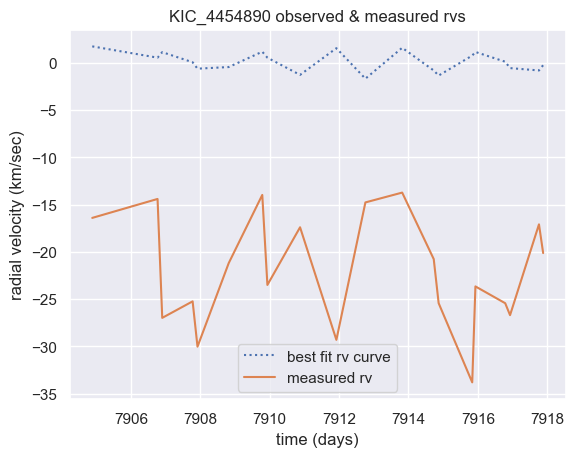

KIC target: KIC_4480434
max value is  1143.744419916166
min value is  64.50025053602828
theta value is  5.3626939891128105 rad
q value is  0.18222480592623314
inclination angle value is  0.4269599011756489
Experimental p value =  [64.50025054]
Theoretical p value = 7.377758908227871
We do not have a binary system



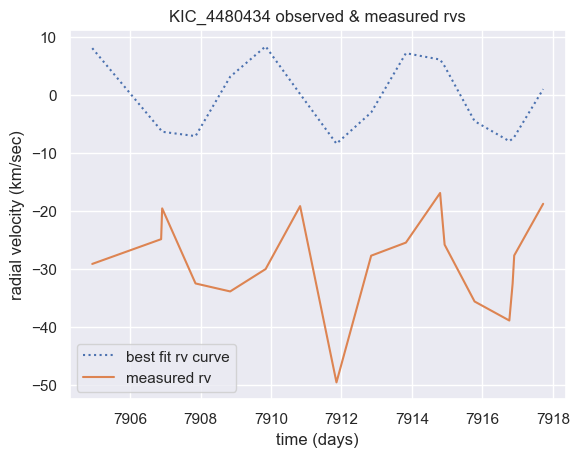

KIC target: KIC_5213142
max value is  1163.6254436062463
min value is  3.6094360363141607
theta value is  4.1528742115107375 rad
q value is  0.26845770231426513
inclination angle value is  0.12865532635019122
Experimental p value =  [3.60943604]
Theoretical p value = 7.377758908227871
We have a binary system



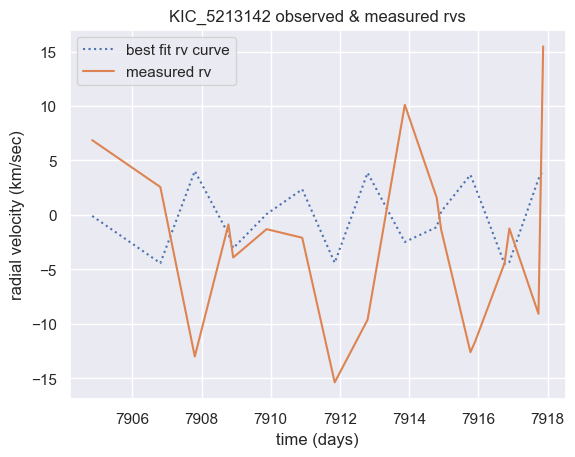

KIC target: KIC_5553362
max value is  1069.621471949045
min value is  25.705451029786396
theta value is  2.3122306867664464 rad
q value is  0.17503438711778596
inclination angle value is  0.8073404869670545
Experimental p value =  [25.70545103]
Theoretical p value = 7.377758908227871
We do not have a binary system



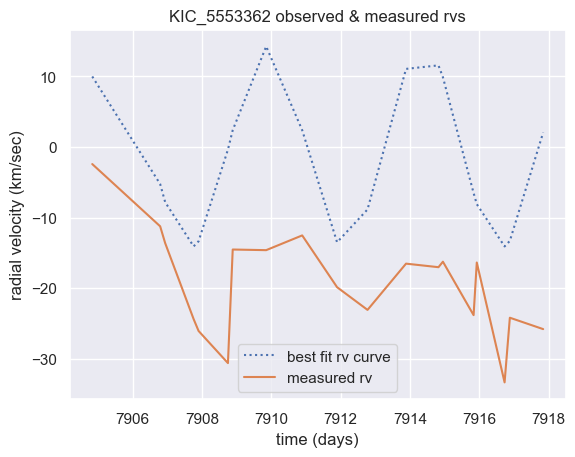

KIC target: KIC_6425783
max value is  1023.9537456418581
min value is  46.25008292794568
theta value is  5.728548307055836 rad
q value is  0.0017527415005487157
inclination angle value is  1.505285151802611
Experimental p value =  [46.25008293]
Theoretical p value = 7.377758908227871
We do not have a binary system



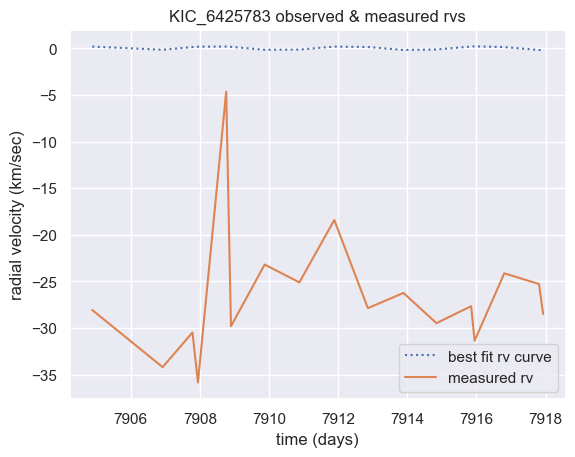

KIC target: KIC_6780052
max value is  1235.5836345663417
min value is  34.93896805356715
theta value is  2.520584646747101 rad
q value is  0.1619995793294734
inclination angle value is  0.46525620045835786
Experimental p value =  [34.93896805]
Theoretical p value = 7.377758908227871
We do not have a binary system



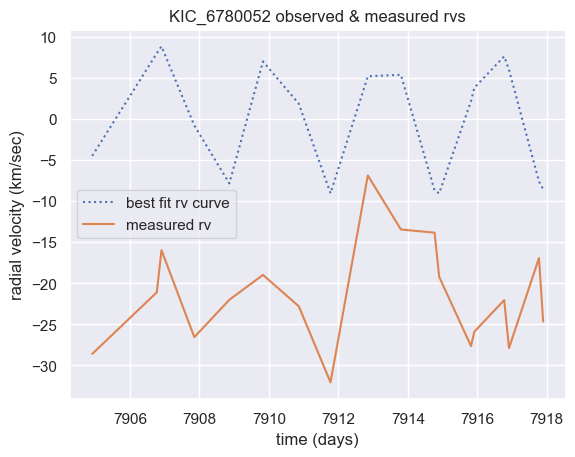

KIC target: KIC_6844101
max value is  1422.9955090177828
min value is  35.60369559076513
theta value is  3.4207205589053604 rad
q value is  0.16630219630093102
inclination angle value is  0.879438519202834
Experimental p value =  [35.60369559]
Theoretical p value = 7.377758908227871
We do not have a binary system



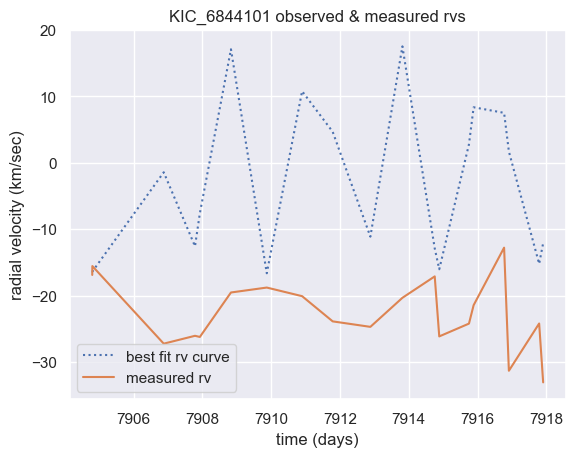

KIC target: KIC_7421325
max value is  983.5134841117006
min value is  13.039842843159157
theta value is  1.2854225102500534 rad
q value is  0.13276036716066963
inclination angle value is  0.9427550660032948
Experimental p value =  [13.03984284]
Theoretical p value = 7.377758908227871
We do not have a binary system



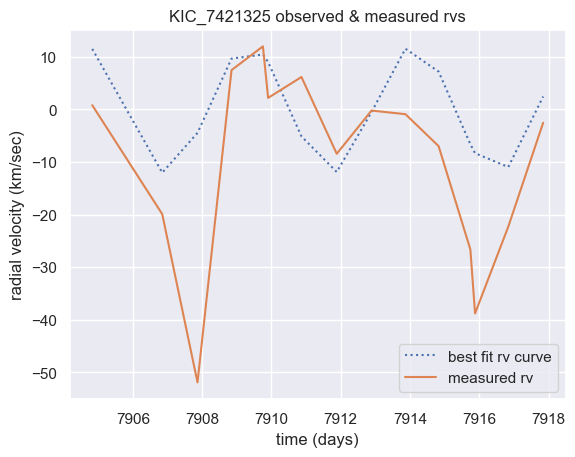

KIC target: KIC_7919763
max value is  1100.367513874466
min value is  21.736687727265988
theta value is  4.062001001456624 rad
q value is  0.012598477766624816
inclination angle value is  1.2335327998687227
Experimental p value =  [21.73668773]
Theoretical p value = 7.377758908227871
We do not have a binary system



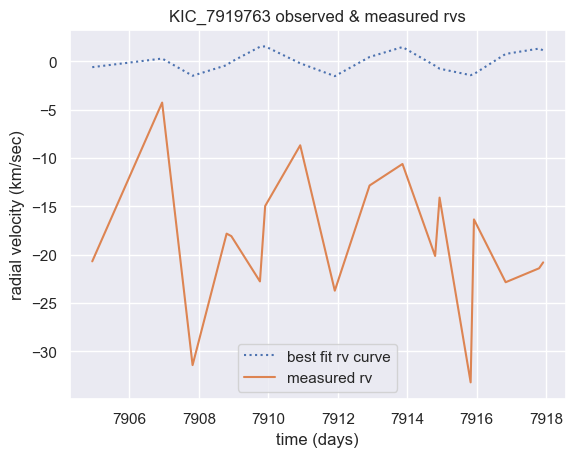

KIC target: KIC_8442720
max value is  1354.4087363794827
min value is  192.68337913319255
theta value is  1.3680179159232189 rad
q value is  0.012598477766624816
inclination angle value is  1.3744505731415733
Experimental p value =  [192.68337913]
Theoretical p value = 7.377758908227871
We do not have a binary system



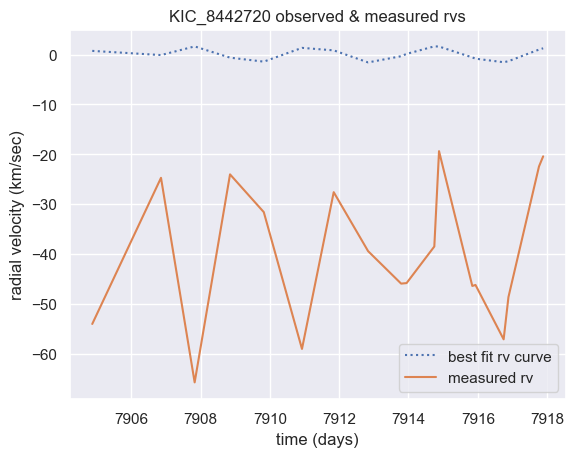

KIC target: KIC_8651471
max value is  868.5146849272413
min value is  2.761436191760856
theta value is  3.662130364276496 rad
q value is  0.0017081971287391529
inclination angle value is  0.8955170569605149
Experimental p value =  [2.76143619]
Theoretical p value = 7.377758908227871
We have a binary system



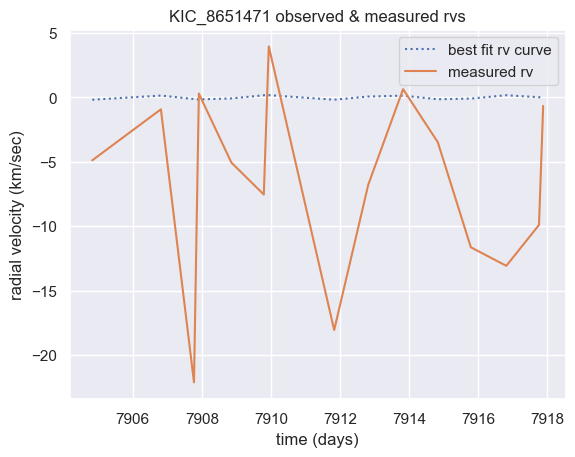

KIC target: KIC_9151271
max value is  3061.3580999380147
min value is  454.657101782613
theta value is  2.9460505260306133 rad
q value is  0.2585833122455715
inclination angle value is  1.1747502395877967
Experimental p value =  [454.65710178]
Theoretical p value = 7.377758908227871
We do not have a binary system



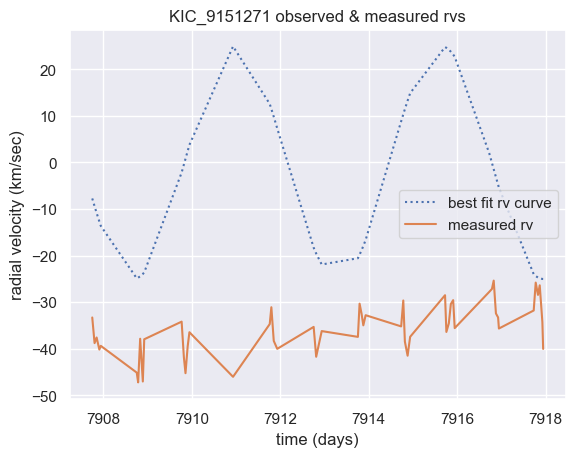

KIC target: KIC_9653110
max value is  1411.0844467893958
min value is  98.91548205293891
theta value is  1.771961062604089 rad
q value is  0.11230588129536467
inclination angle value is  0.836631561733996
Experimental p value =  [98.91548205]
Theoretical p value = 7.377758908227871
We do not have a binary system



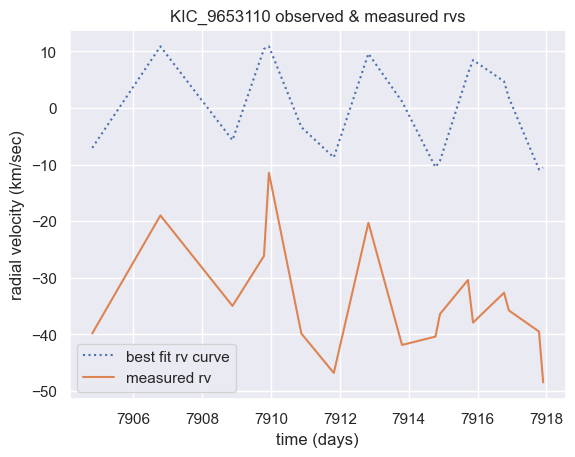

KIC target: KIC_9655045
max value is  339.5309767804109
min value is  0.0062948233282640745
theta value is  2.3778060938276706 rad
q value is  0.009632803532528822
inclination angle value is  1.3438767108158558
Experimental p value =  [0.00629482]
Theoretical p value = 7.377758908227871
We have a binary system



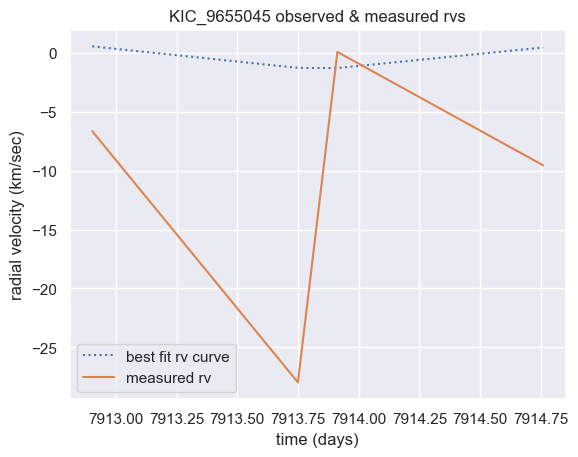

KIC target: KIC_9710336
max value is  1175.830870749365
min value is  30.21496037022361
theta value is  1.2791222926531713 rad
q value is  0.17050011205657845
inclination angle value is  1.24576809692958
Experimental p value =  [30.21496037]
Theoretical p value = 7.377758908227871
We do not have a binary system



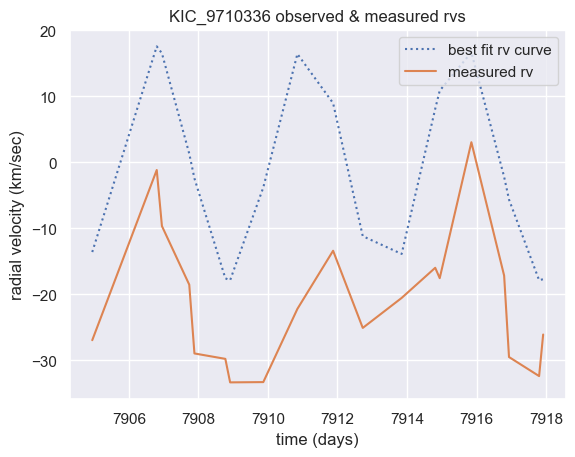

KIC target: KIC_9964938
max value is  1082.6404387116288
min value is  2.347751500514384
theta value is  3.4750890926140414 rad
q value is  0.01576631439121201
inclination angle value is  1.0902870451703859
Experimental p value =  [2.3477515]
Theoretical p value = 7.377758908227871
We have a binary system



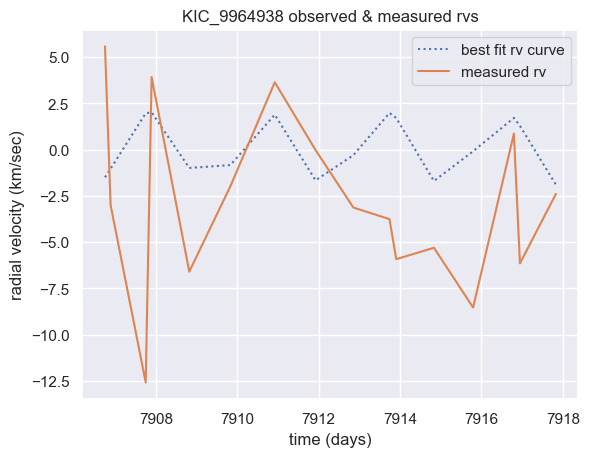

KIC target: KIC_11819949
max value is  1454.9277338176057
min value is  4.319427218703725
theta value is  1.0458237573595481 rad
q value is  0.06597599868161919
inclination angle value is  1.4058144245499642
Experimental p value =  [4.31942722]
Theoretical p value = 7.377758908227871
We have a binary system



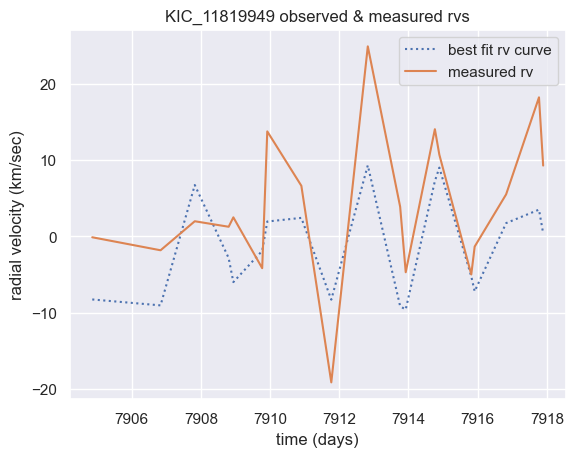

KIC target: KIC_12736892
max value is  1203.9809189656175
min value is  3.2078698190599204
theta value is  0.16113347648168877 rad
q value is  0.16841383963696233
inclination angle value is  1.0031963380171929
Experimental p value =  [3.20786982]
Theoretical p value = 7.377758908227871
We have a binary system



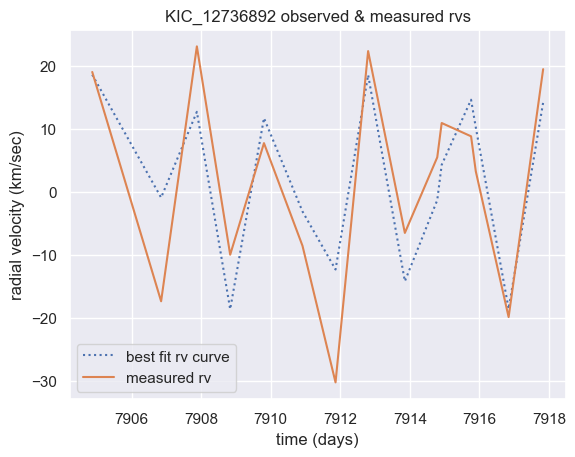

In [11]:
Binary_Model()